<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/4b_mrf_quita_ruido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quitar ruido de imágenes con campos aleatorios de Markov
En esta libreta programaremos el algoritmo _iterated conditional modes_ para quitar ruido en imágenes representadas mediante campos aleatorios de Markov.

In [1]:
import numpy as np
np.random.seed(2021)

import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.filters import threshold_mean

p_r = 1. / 15
n_iter = 5

## Imagen de prueba
Cargamos una imagen de la biblioteca de `scikit-image`.

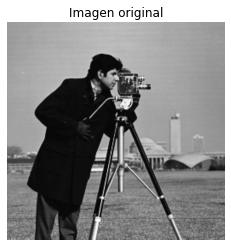

In [2]:
imagen = data.camera()
plt.imshow(imagen, cmap=plt.cm.gray)
plt.title('Imagen original')
plt.axis('off')
plt.show()

Binarizamos la imagen mediante umbralización por la media.

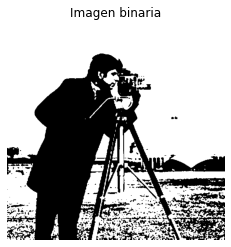

In [3]:
umbral = threshold_mean(imagen)
binaria = (imagen > umbral).astype(np.int32)
binaria[binaria == 0] = -1

plt.imshow(binaria, cmap=plt.cm.gray)
plt.title('Imagen binaria')
plt.axis('off')
plt.show()

Generamos una imagen de ruido aleatorio binario.

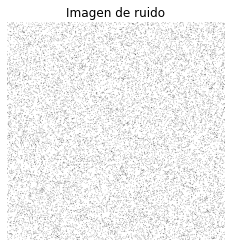

In [4]:
ruido = np.random.choice([-1, 1], size=imagen.shape, p=[p_r, 1 - p_r])
plt.imshow(ruido, cmap=plt.cm.gray)
plt.title('Imagen de ruido')
plt.axis('off')
plt.show()

Agregamos ruido a la imagen original.

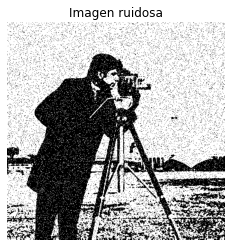

In [5]:
ruidosa = binaria * ruido

plt.imshow(ruidosa, cmap=plt.cm.gray)
plt.title('Imagen ruidosa')
plt.axis('off')
plt.show()

## Algoritmo _iterated conditional modes_
Primero definimos una función que calcula la energía total, definida por
$$
    E(\mathbf{X}, \mathbf{Y}) = \alpha \cdot \sum_ix_i - \beta \cdot \sum_{\{i,j\}}x_ix_j - \eta \cdot \sum_i x_iy_i
$$


In [6]:
def energia(X, Y, i, j, alfa, beta, eta):
  exy = X[i][j] * Y[i][j]

  exx = 0
  if i-1 >= 0 and j-1 >=0:
    exx += X[i-1][j-1] * X[i][j]

  if i-1 >= 0 and j+1 < Y.shape[1]:
    exx += X[i-1][j+1] * X[i][j]

  if i+1 < Y.shape[0] and j-1 >=0:
    exx += X[i+1][j-1] * X[i][j]

  if i+1 < Y.shape[0] and j+1 < Y.shape[1]:
    exx += X[i+1][j+1] * X[i][j]

  ex = X[i][j]

  return -alfa * exy - beta * exx + eta * ex

Definimos la función para el algoritmo _iterated conditional modes_ (ICM):

1. Inicializa $x_i = y_i$
2. Calcula la energía dado que un nodo o vértice $x_i = +1$ y $x_i = -1$ y fija el  valor con menor energía. 
3. Repite 2 hasta cumplir criterio de paro

In [7]:
def mrf_quitaruido(im, alfa, beta, eta, n_iter=2):
  im_noruido = np.zeros((n_iter, im.shape[0], im.shape[1]))
  X = im.copy()
  for k in range(n_iter):
    for i in range(im.shape[0]):
      for j in range(im.shape[1]):
        X[i][j] = -1
        a = energia(X, im, i, j, alfa, beta, eta)
        
        X[i][j] = 1
        b = energia(X, im, i, j, alfa, beta, eta)
  
        if a < b:
          X[i][j] = -1

    im_noruido[k] = X


  return im_noruido

## Quitando ruido
Finalmente, aplicamos el algoritmo ICM a la imagen ruidosa para quitarle el ruido.

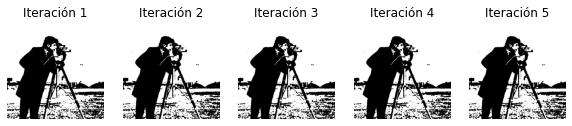

In [8]:
imagen_noruido = mrf_quitaruido(ruidosa, 2, 2, -1, n_iter=n_iter)

fig, axs = plt.subplots(1, n_iter, figsize=(10,25))
for i in range(n_iter):
  axs[i].imshow(imagen_noruido[i], cmap=plt.cm.gray)
  axs[i].set_title(u'Iteración ' + str(i + 1))
  axs[i].axis('off')
plt.show()

Comparamos la imagen original, binaria, ruidosa y la resultante de quitar el ruido.

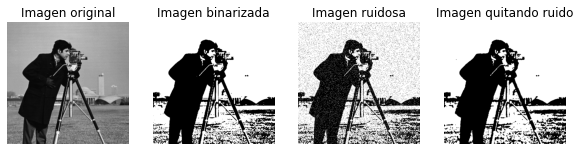

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(10,25))

axs[0].imshow(imagen, cmap=plt.cm.gray)
axs[0].set_title('Imagen original')
axs[0].axis('off')

axs[1].imshow(binaria, cmap=plt.cm.gray)
axs[1].set_title('Imagen binarizada')
axs[1].axis('off')

axs[2].imshow(ruidosa, cmap=plt.cm.gray)
axs[2].set_title('Imagen ruidosa')
axs[2].axis('off')

axs[3].imshow(imagen_noruido[-1], cmap=plt.cm.gray)
axs[3].set_title('Imagen quitando ruido')
axs[3].axis('off')
plt.show()